In [15]:
from elasticsearch8 import Elasticsearch
import json
def main():
    try:
        es = Elasticsearch (
                'https://127.0.0.1:9200',
                request_timeout=60,
                verify_certs= False,
                ssl_show_warn= False,
                basic_auth=('elastic','elastic')
            )

        query = {
            "size": 10000,
            "query": {
                "match_all": {}
            }
        }

        result = es.search(index="air-qualities", body=query)
        air_qualities = result['hits']['hits']

        air_quality_dict = {}

        for hit in air_qualities:
            source = hit['_source']
            site_id = source['siteID']
            since = source['since']
            
            if site_id not in air_quality_dict:
                air_quality_dict[site_id] = {}
            
            if since not in air_quality_dict[site_id]:
                air_quality_dict[site_id][since] = []

            air_quality_dict[site_id][since].append(source)

        response = {'status_code': 200, 'data':air_quality_dict}
        return json.dumps(response)

    except Exception as e:
        error_response = {'status_code': 500, 'error_message': str(e)}
        return json.dumps(error_response)



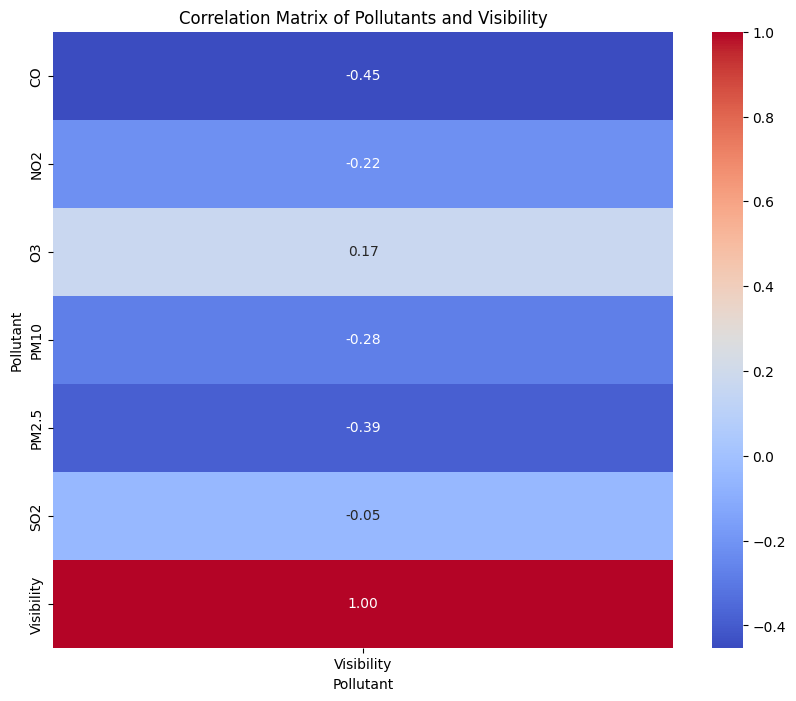

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
response = requests.get("http://127.0.0.1:9090/EPA/get-air-qualities")
data = response.json().get('data')
rows = []
for site_id, site_data in data.items():
    for since, since_data in site_data.items():
        for item in since_data:
            data_row = {
                'siteID': site_id,
                'since': since,
                'dataName': item['dataName'],
                'averageValue': item['averageValue']
            }
            rows.append(data_row)
df = pd.DataFrame(rows)

pivot_df = df.pivot_table(index=['siteID', 'since'], columns='dataName', values='averageValue')
pivot_df.fillna(pivot_df.median(), inplace=True)
pivot_df = pivot_df.drop(columns=['API',"Particles"])
# 计算相关性矩阵
correlation_matrix = pivot_df.corr()

# 绘制相关性矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Visibility']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pollutants and Visibility')
plt.xlabel('Pollutant')
plt.ylabel('Pollutant')
plt.show()
